(1300, 585, 3)

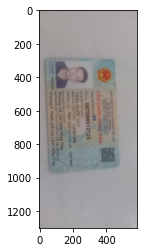

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def read_img_as_array(img_path):
    image = Image.open(img_path)
    return np.asarray(image)

image = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-raw/cccd4.jpg')

plt.imshow(image)
image.shape

# Corners detection

### Alignment helper function

In [3]:
def get_center_point(coordinate_dict):
    di = dict()

    for key in coordinate_dict.keys():
        xmin, ymin, xmax, ymax = coordinate_dict[key]
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        di[key] = (x_center, y_center)

    return di


def find_miss_corner(coordinate_dict):
    position_name = ['top_left', 'top_right', 'bottom_left', 'bottom_right']
    position_index = np.array([0, 0, 0, 0])

    for name in coordinate_dict.keys():
        if name in position_name:
            position_index[position_name.index(name)] = 1

    index = np.argmin(position_index)

    return position_name[index]


def calculate_missed_coord_corner(coordinate_dict):
    thresh = 0

    index = find_miss_corner(coordinate_dict)

    # calculate missed corner coordinate
    # case 1: missed corner is "top_left"
    if index == 'top_left':
        midpoint = np.add(coordinate_dict['top_right'], coordinate_dict['bottom_left']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_right'][0] - thresh
        coordinate_dict['top_left'] = (x, y)
    elif index == 'top_right':  # "top_right"
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_left'][0] - thresh
        coordinate_dict['top_right'] = (x, y)
    elif index == 'bottom_left':  # "bottom_left"
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_right'][0] - thresh
        coordinate_dict['bottom_left'] = (x, y)
    elif index == 'bottom_right':  # "bottom_right"
        midpoint = np.add(coordinate_dict['bottom_left'], coordinate_dict['top_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_left'][0] - thresh
        coordinate_dict['bottom_right'] = (x, y)

    return coordinate_dict


def perspective_transform(image, source_points):
    dest_points = np.float32([[0, 0], [500, 0], [500, 300], [0, 300]])
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    dst = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))

    return dst


def align_image(image, coordinate_dict):
    # Interpolate if just have 3 points
    if len(coordinate_dict) < 3:
        # raise ValueError('Image may be right angle! or Please try again')
        print('Image may be right angle! or Please try again')
        return image

    # convert (xmin, ymin, xmax, ymax) to (x_center, y_center)
    coordinate_dict = get_center_point(coordinate_dict)

    if len(coordinate_dict) == 3:
        coordinate_dict = calculate_missed_coord_corner(coordinate_dict)

    top_left_point = coordinate_dict['top_left']
    top_right_point = coordinate_dict['top_right']
    bottom_right_point = coordinate_dict['bottom_right']
    bottom_left_point = coordinate_dict['bottom_left']

    source_points = np.float32([top_left_point, top_right_point, bottom_right_point, bottom_left_point])

    # transform image and crop
    crop = perspective_transform(image, source_points)

    return crop


### Roboflow corner detection model 

loading Roboflow workspace...
loading Roboflow project...


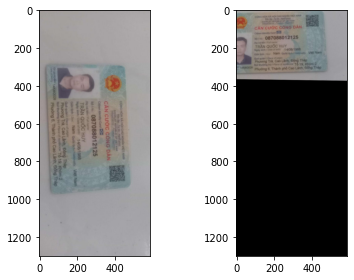

In [4]:
import supervision as sv
from roboflow import Roboflow
from supervision import BoxAnnotator

rf = Roboflow(api_key="JSVeJAx7mmzoT48naM0W")
project = rf.workspace().project("4corners-gwkuc")
model = project.version(5).model

def get_corners_from_detector(result):
    detection_boxes = []
    detection_classes = []
    category_index = {}

    for prediction in result['predictions']:
        x = prediction['x']
        y = prediction['y']
        width = prediction['width']
        height = prediction['height']
        class_id = prediction['class_id'] + 1
        class_name = prediction['class']

        # Convert the bounding box coordinates to the format [y01, x01, y02, x02]
        detection_boxes.append([y, x, y + height, x + width])
        detection_classes.append(class_id)
        category_index[class_id] = {'id': class_id, 'name': class_name}

    return detection_boxes, detection_classes, category_index

def transform_based_corner_detect(image):
    result = model.predict(image, confidence=40, overlap=30).json()
    # print(result)

    # Call the function with the result JSON
    detection_boxes, detection_classes, category_index = get_corners_from_detector(result)

    # print('Detection boxes, detection classes and category index respectively',
    #         detection_boxes, detection_classes, category_index)

    # print(f'Detection boxed: \n {detection_boxes},'
    #         f'\n Detection classes: \n {detection_classes}')

    coordinate_dict = dict()
    height, width, _ = image.shape

    for i in range(len(detection_classes)):
        label = str(category_index[detection_classes[i]]['name'])
        real_ymin = int(max(1, detection_boxes[i][0]))
        real_xmin = int(max(1, detection_boxes[i][1]))
        real_ymax = int(min(height, detection_boxes[i][2]))
        real_xmax = int(min(width, detection_boxes[i][3]))
        coordinate_dict[label] = (real_xmin, real_ymin, real_xmax, real_ymax)

    coordinate_dict = {
    key.replace('topleft', 'top_left').replace('topright', 'top_right').replace('botleft', 'bottom_left').replace('botright', 'bottom_right'): value for key, value in coordinate_dict.items()}

    # print(f'Coordinate dict: \n {coordinate_dict}')

    # align image
    cropped_img = align_image(image, coordinate_dict)

    return cropped_img

cropped_img = transform_based_corner_detect(image)

#### Original vs cropped plot
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

# Display images in subplots
ax1.imshow(image)
ax2.imshow(cropped_img)

# Adjust layout (optional)
plt.tight_layout()

# Show the plot
plt.show()

### Corner detection test many images

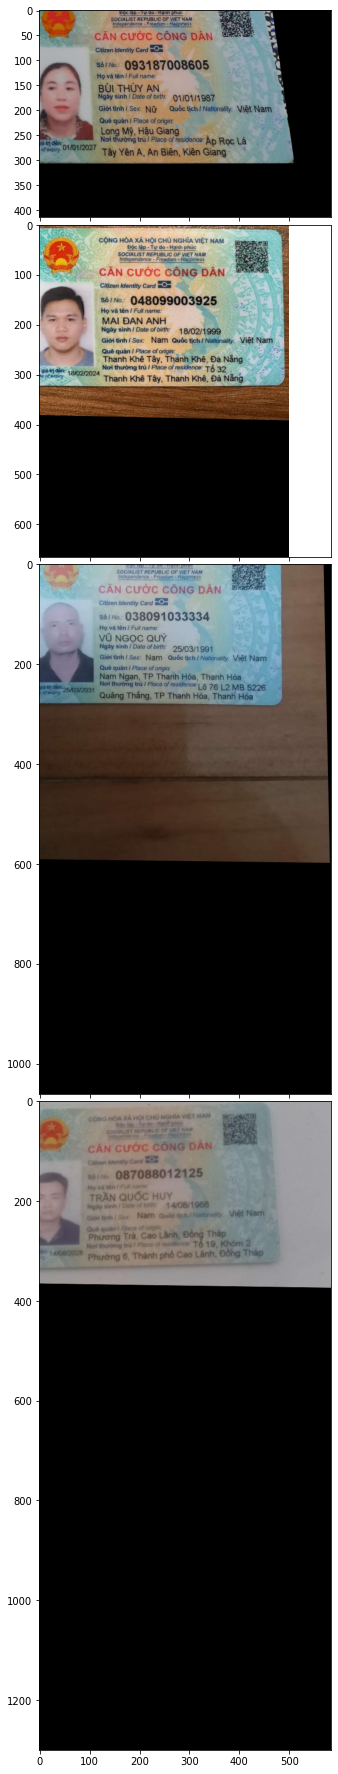

In [8]:
import os
from mpl_toolkits.axes_grid1 import ImageGrid

imgs_path = 'C:/Users/Admin/Desktop/A.N lab/test_imgs'
paths = os.listdir(imgs_path)

# Create an empty list to store image arrays
img_arr = []

for path in paths:
    img_dir = f'{imgs_path}/{path}'
    img = Image.open(img_dir)
    img = np.asarray(img)

    # Check if the image has 4 channels (RGBA)
    if len(img.shape) > 2 and img.shape[2] == 4:
        # Convert RGBA to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    # 4 corners detection
    cropped = transform_based_corner_detect(img)
    img_arr.append(cropped)


# Define the grid layout
rows, cols = int(len(img_arr)), 1

fig = plt.figure(figsize=(32 * rows, 32 * cols))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.1)

# Display images in the grid
for ax, im in zip(grid, img_arr):
    ax.imshow(im)

# Adjust layout (optional)
# plt.tight_layout()

# Show the plot
plt.show()

# Text detection

(640, 640, 3)

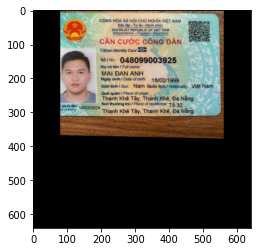

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def read_img_as_array(img_path):
    image = Image.open(img_path)
    return np.asarray(image)

def resize_fit_black_edge(image, target_size=(640, 640)):
    # Get the original image dimensions
    original_height, original_width, _ = image.shape

    # Calculate the scaling factors for width and height
    width_scale = target_size[0] / original_width
    height_scale = target_size[1] / original_height

    # Determine the scaling factor to fit the image within the target size
    scale_factor = min(width_scale, height_scale)

    # Resize the image while maintaining the aspect ratio
    resized_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    # Create a black canvas of the target size
    canvas = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

    # Calculate the position to paste the resized image
    x_offset = (target_size[0] - resized_image.shape[1]) // 2
    y_offset = (target_size[1] - resized_image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset + resized_image.shape[0], x_offset:x_offset + resized_image.shape[1]] = resized_image

    return canvas

image = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-raw/cccd4.jpg')
cropped_img = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment/image1.jpg')


# model input size (640, 640)
# so preprocess image by resize_fit_black_edge (without distortion)
cropped_img = resize_fit_black_edge(cropped_img)

plt.imshow(cropped_img)
cropped_img.shape

In [2]:
from roboflow import Roboflow
import supervision as sv
import cv2

rf = Roboflow(api_key="JSVeJAx7mmzoT48naM0W")
project = rf.workspace().project("text-detection-from-id-card")
model = project.version(3).model

# Object detection output: https://docs.roboflow.com/deploy/hosted-api/custom-models/object-detection
# cropped_img_path = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment/image1.jpg'
result = model.predict(cropped_img, confidence=50, overlap=50).json()

loading Roboflow workspace...
loading Roboflow project...


#### Ouput from Roboflow as righ format
- Get detection boxes, detection classes from Roboflow result
- Apply NMS
- Return boxes, classes.astype('int), category_index

In [3]:
## Get detection boxes, detection classes from Roboflow result
def get_corners(result):
    detection_boxes = []
    detection_classes = []
    category_index = {}

    for prediction in result['predictions']:
        x_center = prediction['x']
        y_center = prediction['y']
        width = prediction['width']
        height = prediction['height']
        class_id = prediction['class_id'] + 1
        class_name = prediction['class']

        x1 = x_center - (width/2)
        y1 = y_center - (height/2)
        x2 = x_center + (width/2)
        y2 = y_center + (height/2)

        # Convert the bounding box coordinates to the format [y01, x01, y02, x02]
        detection_boxes.append([y1, x1, y2, x2])
        detection_classes.append(class_id)
        category_index[class_id] = {'id': class_id, 'name': class_name}

    detection_boxes = np.array(detection_boxes) # casting as array
    detection_classes = np.array(detection_classes).astype('float') # float converting
    
    return detection_boxes, detection_classes, category_index

detection_boxes, detection_classes, category_index = get_corners(result)
print(f'Raw Detection boxed: \n {detection_boxes},'
        f'\n Detection classes: \n {detection_classes}'
        f'\n Detection classes: \n {category_index}'
    )

## Apply NMS
def non_max_suppression_fast(boxes, labels, overlapThresh):
    """ filters object detector predictions / removes duplicates

    Args:
        boxes: 
        labels:
        overlap threshold: 
    Returns:
        the bounding boxes that were picked using the integer data type
    """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return [None, None]

    # if the bounding boxes are integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    #
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 1]
    y1 = boxes[:, 0]
    x2 = boxes[:, 3]
    y2 = boxes[:, 2]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    final_labels = [labels[idx] for idx in pick]
    final_boxes = boxes[pick].astype("int")
    return final_boxes, final_labels

detection_boxes, detection_classes = non_max_suppression_fast(boxes=detection_boxes,
                                                                        labels=detection_classes,
                                                                        overlapThresh=0.15)
## Return boxes, classes.astype('int), category_index
detection_classes = np.array(detection_classes).astype("int")

Raw Detection boxed: 
 [[177. 285. 195. 327.]
 [177. 200. 195. 235.]
 [177. 240. 195. 281.]
 [197. 347. 215. 433.]
 [133. 251. 162. 425.]],
 Detection classes: 
 [3. 3. 3. 1. 2.]
 Detection classes: 
 {3: {'id': 3, 'name': 'name'}, 1: {'id': 1, 'name': 'birthday'}, 2: {'id': 2, 'name': 'id'}}


#### Sort text helper function

The new dictionary with names as keys and indexes as values is {'name': 3, 'birthday': 1, 'id': 2}


In [26]:
def get_y1(x):
    return x[0]


def get_x1(x):
    return x[1]

def get_names_as_keys(dictionary):
    new_dict = {}
    for key, value in dictionary.items():
        new_dict[value['name']] = key
    return new_dict

def sort_each_category(category_text_boxes):
    try:
        min_y1 = min(category_text_boxes, key=get_y1)[0]
    except:
        return None

    mask = np.where(category_text_boxes[:, 0] < min_y1 + 10, True, False)
    line1_text_boxes = category_text_boxes[mask]
    line2_text_boxes = category_text_boxes[np.invert(mask)]

    line1_text_boxes = sorted(line1_text_boxes, key=get_x1)
    line2_text_boxes = sorted(line2_text_boxes, key=get_x1)

    if len(line2_text_boxes) != 0:
        merged_text_boxes = [*line1_text_boxes, *line2_text_boxes]
    else:
        merged_text_boxes = line1_text_boxes

    return merged_text_boxes

def sort_text(detection_boxes, detection_labels, idxs):
    """Merge/ sort text boxes according to coordinate since each class/label 
    may have many boxes.
    Args:
    - detection boxes
    - detection labels
    Return:
    - arranged id_boxes, name_boxes, birth_boxes according to its coordinate

    """
    
    #  Get boxes correspond to its label 
    detection_labels = np.array(detection_labels)
    id_boxes = detection_boxes[detection_labels == idxs['id']]
    birth_boxes = detection_boxes[detection_labels == idxs['birthday']]
    name_boxes = detection_boxes[detection_labels == idxs['name']]
    # home_boxes = detection_boxes[detection_labels == 4]
    # add_boxes = detection_boxes[detection_labels == 5]

    # arrange boxes
    id_boxes = sort_each_category(id_boxes)
    name_boxes = sort_each_category(name_boxes)
    birth_boxes = sort_each_category(birth_boxes)
    # home_boxes = sort_each_category(home_boxes)
    # add_boxes = sort_each_category(add_boxes)

    return id_boxes, name_boxes, birth_boxes

# sort text boxes according to coordinate
idxs = get_names_as_keys(category_index) # get correct label
id_boxes, name_boxes, birth_boxes = sort_text(detection_boxes, detection_classes, idxs)
print(
    f'After sorting function:'
    f'\n id \n {id_boxes} with idx {idxs['id']}',
    f'\n name \n {name_boxes} with idx {idxs['name']}',
    f'\n birth \n {birth_boxes} with idx {idxs['birthday']}',
)

SyntaxError: f-string: unmatched '[' (3783444514.py, line 67)

Category_index: {3: {'id': 3, 'name': 'name'}, 1: {'id': 1, 'name': 'birthday'}, 2: {'id': 2, 'name': 'id'}}


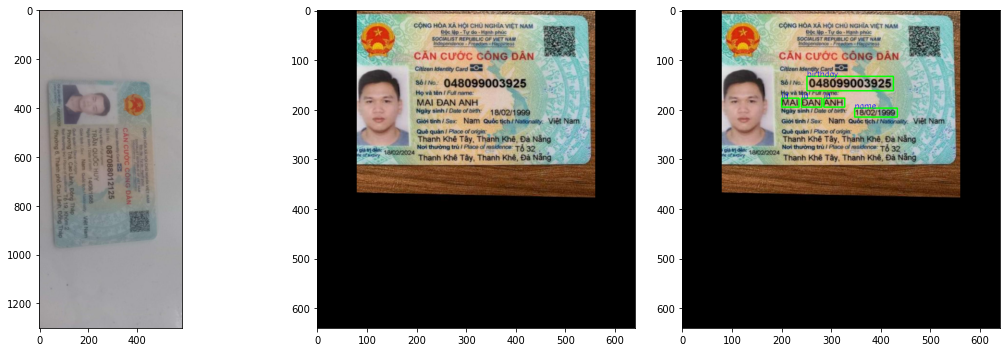

In [19]:
print(f'Category_index: {category_index}')
def draw_text_detected(cropped_img, all_boxes):
    cr_img = np.copy(cropped_img)
    for idx, idx_boxes in enumerate(all_boxes):
        for box in idx_boxes:
            # draw bounding box
            start_point = (box[1], box[0])
            end_point = (box[3], box[2])
            color = (0, 255, 0)
            img = cv2.rectangle(cr_img, start_point, end_point, color, 2) 

            # Draw label
            label = str(category_index[idx + 1]['name'])
            cv2.putText(cr_img, label, (start_point[0], start_point[1]), cv2.FONT_HERSHEY_SIMPLEX, color=(0, 0, 255),
                fontScale=0.5)
    return cr_img

all_boxes = [id_boxes, name_boxes, birth_boxes]
text_detected_img = draw_text_detected(cropped_img, all_boxes)

#### Original vs cropped plot
# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Display images in subplots
ax1.imshow(image)
ax2.imshow(cropped_img)
ax3.imshow(text_detected_img)

# Adjust layout (optional)
plt.tight_layout()

# Show the plot
plt.show()

# Text recognition

After sorting function:
 id 
 [array([133, 251, 162, 425])] 
 name 
 [array([177, 200, 195, 235]), array([177, 240, 195, 281]), array([177, 285, 195, 327])] 
 birth 
 [array([197, 347, 215, 433])]


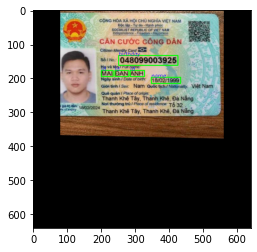

In [18]:
print(
    f'After sorting function:'
    f'\n id \n {id_boxes}',
    f'\n name \n {name_boxes}',
    f'\n birth \n {birth_boxes}',
)
plt.imshow(text_detected_img)

#### CNN (VGG)

In [11]:
import torch
from torch import nn
from torchvision import models


class Vgg(nn.Module):
    def __init__(self, name, ss, ks, hidden, pretrained=True, dropout=0.5):
        super(Vgg, self).__init__()
        cnn = models.vgg19_bn(pretrained=pretrained)

        pool_idx = 0
        
        for i, layer in enumerate(cnn.features):
            if isinstance(layer, torch.nn.MaxPool2d):        
                cnn.features[i] = torch.nn.AvgPool2d(kernel_size=ks[pool_idx], stride=ss[pool_idx], padding=0)
                pool_idx += 1
 
        self.features = cnn.features
        self.dropout = nn.Dropout(dropout)
        self.last_conv_1x1 = nn.Conv2d(512, hidden, 1)

    def forward(self, x):
        """
        Shape: 
            - x: (N, C, H, W)
            - output: (W, N, C)
        """

        conv = self.features(x)
        conv = self.dropout(conv)
        conv = self.last_conv_1x1(conv)

        conv = conv.transpose(-1, -2)
        conv = conv.flatten(2)
        conv = conv.permute(-1, 0, 1)
        return conv


def vgg19_bn(ss, ks, hidden, pretrained=True, dropout=0.5):
    return Vgg('vgg19_bn', ss, ks, hidden, pretrained, dropout)

class CNN(nn.Module):
    def __init__(self, backbone, **kwargs):
        super(CNN, self).__init__()
        self.model = vgg19_bn(**kwargs)

    def forward(self, x):
        return self.model(x)

    def freeze(self):
        for name, param in self.model.features.named_parameters():
            if name != 'last_conv_1x1':
                param.requires_grad = False

    def unfreeze(self):
        for param in self.model.features.parameters():
            param.requires_grad = True

#### Language Transformer

In [12]:
import math
import torch
from torch import nn

class LanguageTransformer(nn.Module):
    def __init__(self, vocab_size, 
                 d_model, nhead, 
                 num_encoder_layers, num_decoder_layers, 
                 dim_feedforward, max_seq_length, 
                 pos_dropout, trans_dropout):
        super().__init__()
        
        self.d_model = d_model
        self.embed_tgt = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(d_model, nhead, 
                                          num_encoder_layers, num_decoder_layers, 
                                          dim_feedforward, trans_dropout)
        
        self.fc = nn.Linear(d_model, vocab_size)
        
    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        Shape:
            - src: (W, N, C)
            - tgt: (T, N) 
            - src_key_padding_mask: (N, S)
            - tgt_key_padding_mask: (N, T)
            - memory_key_padding_mask: (N, S)
            - output: (N, T, E)
            
        """
        tgt_mask = self.gen_nopeek_mask(tgt.shape[0]).to(src.device)
        
        src = self.pos_enc(src*math.sqrt(self.d_model))

        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))
        
        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        output = output.transpose(0, 1)
        return self.fc(output)

    def gen_nopeek_mask(self, length):
        mask = (torch.triu(torch.ones(length, length)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

        return mask
    
    def forward_encoder(self, src):
        src = self.pos_enc(src*math.sqrt(self.d_model))
        memory = self.transformer.encoder(src)
        return memory
    
    def forward_decoder(self, tgt, memory):
        tgt_mask = self.gen_nopeek_mask(tgt.shape[0]).to(tgt.device)
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))
        
        output = self.transformer.decoder(tgt, memory, tgt_mask=tgt_mask)
        output = output.transpose(0, 1)

        return self.fc(output), memory
    
    def expand_memory(self, memory, beam_size):
        memory = memory.repeat(1, beam_size, 1)
        return memory
    
    def get_memory(self, memory, i):
        memory = memory[:, [i], :]
        return memory

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]

        return self.dropout(x)
 
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(LearnedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.pos_embed = nn.Embedding(max_len, d_model)
        self.layernorm = LayerNorm(d_model)

    def forward(self, x):
        seq_len = x.size(0)
        pos = torch.arange(seq_len, dtype=torch.long, device=x.device)
        pos = pos.unsqueeze(-1).expand(x.size()[:2])
        x = x + self.pos_embed(pos)
        return self.dropout(self.layernorm(x))

class LayerNorm(nn.Module):
    "A layernorm module in the TF style (epsilon inside the square root)."
    def __init__(self, d_model, variance_epsilon=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta  = nn.Parameter(torch.zeros(d_model))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta  


### VietOCR

In [13]:
from torch import nn

class VietOCR(nn.Module):
    def __init__(self, vocab_size,
                    backbone,
                    cnn_args, 
                    transformer_args, seq_modeling='transformer'):
        
        super(VietOCR, self).__init__()
        
        self.cnn = CNN(backbone, **cnn_args)
        self.transformer = LanguageTransformer(vocab_size, **transformer_args)

    def forward(self, img, tgt_input, tgt_key_padding_mask):
        """
        Shape:
            - img: (N, C, H, W)
            - tgt_input: (T, N)
            - tgt_key_padding_mask: (N, T)
            - output: b t v
        """
        src = self.cnn(img)
        outputs = self.transformer(src, tgt_input, tgt_key_padding_mask=tgt_key_padding_mask)
        return outputs

#### Vocal

In [14]:
class Vocab():
    def __init__(self, chars):
        self.pad = 0
        self.go = 1
        self.eos = 2
        self.mask_token = 3

        self.chars = chars

        self.c2i = {c:i+4 for i, c in enumerate(chars)}

        self.i2c = {i+4:c for i, c in enumerate(chars)}
        
        self.i2c[0] = '<pad>'
        self.i2c[1] = '<sos>'
        self.i2c[2] = '<eos>'
        self.i2c[3] = '*'

    def encode(self, chars):
        return [self.go] + [self.c2i[c] for c in chars] + [self.eos]
    
    def decode(self, ids):
        first = 1 if self.go in ids else 0
        last = ids.index(self.eos) if self.eos in ids else None
        sent = ''.join([self.i2c[i] for i in ids[first:last]])
        return sent
    
    def __len__(self):
        return len(self.c2i) + 4
    
    def batch_decode(self, arr):
        texts = [self.decode(ids) for ids in arr]
        return texts

    def __str__(self):
        return self.chars


### Translate and build model

In [15]:
import torch
import numpy as np


def translate(img, model, max_seq_length=128, sos_token=1, eos_token=2):
    """data: BxCXHxW"""
    model.eval()
    device = img.device

    with torch.no_grad():
        src = model.cnn(img)
        memory = model.transformer.forward_encoder(src)

        translated_sentence = [[sos_token] * len(img)]
        max_length = 0

        while max_length <= max_seq_length and not all(np.any(np.asarray(translated_sentence).T == eos_token, axis=1)):
            tgt_inp = torch.LongTensor(translated_sentence).to(device)
            output, memory = model.transformer.forward_decoder(tgt_inp, memory)
            output = output.to('cpu')

            _, indices = torch.topk(output, 5)

            indices = indices[:, -1, 0]
            indices = indices.tolist()

            translated_sentence.append(indices)
            max_length += 1

            del output

        translated_sentence = np.asarray(translated_sentence).T

    return translated_sentence


def build_model(config):
    vocab = Vocab(config['vocab'])
    device = config['device']
    
    model = VietOCR(len(vocab),
            config['backbone'],
            config['cnn'], 
            config['transformer'],
            config['seq_modeling'])
    
    model = model.to(device)

    return model, vocab

### Predictor

In [16]:
import cv2
import numpy as np
import math
import torch
from collections import defaultdict

class Predictor(object):
    def __init__(self, config):
        device = config['device']

        model, vocab = build_model(config)
        weights = config['weights']

        model.load_state_dict(torch.load(weights, map_location=torch.device(device)))

        self.config = config
        self.model = model
        self.vocab = vocab

    def predict(self, img):
        img = self.preprocess_input(img)
        img = np.expand_dims(img, axis=0)
        img = torch.FloatTensor(img)
        img = img.to(self.config['device'])
        s = translate(img, self.model)[0].tolist()

        s = self.vocab.decode(s)

        return s

    def batch_predict(self, images):
        """
        param: images : list of ndarray
        """
        batch_dict, indices = self.batch_process(images)
        list_keys = [i for i in batch_dict if batch_dict[i] != batch_dict.default_factory()]
        result = list([])

        for width in list_keys:
            batch = batch_dict[width]
            batch = np.asarray(batch)
            batch = torch.FloatTensor(batch)
            batch = batch.to(self.config['device'])
            sent = translate(batch, self.model).tolist()

            batch_text = self.vocab.batch_decode(sent)
            result.extend(batch_text)

        # sort text result to original coordinate
        z = zip(result, indices)
        sorted_result = sorted(z, key=lambda element: element[1])
        result, _ = zip(*sorted_result)

        return result

    def preprocess_input(self, image):
        """
        param: image: ndarray of image
        """
        h, w, _ = image.shape
        new_w, image_height = self.resize_v1(w, h, self.config['dataset']['image_height'],
                                             self.config['dataset']['image_min_width'],
                                             self.config['dataset']['image_max_width'])

        img = cv2.resize(image, (new_w, image_height))
        img = np.transpose(img, (2, 0, 1))
        img = img / 255.0

        return img

    def batch_process(self, images):
        batch_img_dict = defaultdict(list)
        image_height = self.config['dataset']['image_height']

        batch_img_li = [self.preprocess_input(img) for img in images]
        batch_imgs, width_list, indices = self.sort_width(batch_img_li, reverse=False)

        min_bucket_width = min(width_list)
        max_width = max(width_list)
        thresh = 30
        max_bucket_width = np.minimum(min_bucket_width + thresh, max_width)

        for i, image in enumerate(batch_imgs):
            w = image.shape[2]

            # reset min_bucket_width, max_bucket_width
            if w > max_bucket_width:
                min_bucket_width = w
                max_bucket_width = np.minimum(min_bucket_width + thresh, max_width)

            avg_bucket_width = int((max_bucket_width + min_bucket_width) / 2)

            new_img = self.resize_v2(image, avg_bucket_width, height=image_height)
            batch_img_dict[avg_bucket_width].append(new_img)

        return batch_img_dict, indices

    @staticmethod
    def sort_width(batch_img, reverse=False):
        def get_img_width(element):
            img = element[0]
            c, h, w = img.shape
            return w

        batch = list(zip(batch_img, range(len(batch_img))))
        sorted_batch = sorted(batch, key=get_img_width, reverse=reverse)
        sorted_batch_img, indices = list(zip(*sorted_batch))

        return sorted_batch_img, list(map(get_img_width, batch)), indices

    @staticmethod
    def resize_v1(w, h, expected_height, image_min_width, image_max_width):
        new_w = int(expected_height * float(w) / float(h))
        round_to = 10
        new_w = math.ceil(new_w / round_to) * round_to
        new_w = max(new_w, image_min_width)
        new_w = min(new_w, image_max_width)

        return new_w, expected_height

    @staticmethod
    def resize_v2(img, width, height):
        new_img = np.transpose(img, (1, 2, 0))
        new_img = cv2.resize(new_img, (width, height), cv2.INTER_AREA)
        new_img = np.transpose(new_img, (2, 0, 1))

        return new_img




In [17]:
#### Predictor sanity check
text_recognition = {
    'base_config': './src/vietocr/config_text_recognition/base.yml',
    'vgg_config': './src/vietocr/config_text_recognition/vgg-transformer.yml',
    'model_weight': './src/vietocr/config_text_recognition/transformerocr.pth'
}


def load_config():
    # load base config
    ocr_config = read_from_config(file_yml=text_recognition['base_config'])

    # load vgg transformer config
    vgg_config = read_from_config(file_yml=text_recognition['vgg_config'])

    # update base config
    ocr_config.update(vgg_config)

    # load model from checkpoint
    ocr_config['weights'] = text_recognition['model_weight']
    ocr_config['predictor']['beamsearch'] = False

    return ocr_config


### Crop/Aggregate boxes and text recognition

In [37]:
import yaml

text_recognition = {
    'base_config': './src/vietocr/config_text_recognition/base.yml',
    'vgg_config': './src/vietocr/config_text_recognition/vgg-transformer.yml',
    'model_weight': './src/vietocr/config_text_recognition/transformerocr.pth'
}


class TextRecognition(object):
    def __init__(self):
        self.ocr_config = self.load_config()
        self.detector = Predictor(self.ocr_config)

    def load_config(self):
        # load base config
        ocr_config = self.read_from_config(file_yml=text_recognition['base_config'])

        # load vgg transformer config
        vgg_config = self.read_from_config(file_yml=text_recognition['vgg_config'])

        # update base config
        ocr_config.update(vgg_config)

        # load model from checkpoint
        ocr_config['weights'] = text_recognition['model_weight']
        ocr_config['predictor']['beamsearch'] = False

        return ocr_config

    @staticmethod
    def read_from_config(file_yml):
        with open(file_yml, encoding='utf-8') as f:
            config = yaml.safe_load(f)

        return config

    def predict(self, image):
        image = Image.fromarray(image)
        result = self.detector.predict(image)

        return result

    def predict_on_batch(self, batch_images):
        return self.detector.batch_predict(batch_images)


text_recognition_model = TextRecognition()

def regcornize(cropped_img):
    field_dict = dict()

    # crop boxes according to coordinate
    def crop_and_recog(boxes):
        crop = []
        if len(boxes) == 1:
            ymin, xmin, ymax, xmax = boxes[0]
            crop.append(cropped_img[ymin:ymax, xmin:xmax])
        else:
            for box in boxes:
                ymin, xmin, ymax, xmax = box
                crop.append(cropped_img[ymin:ymax, xmin:xmax])

        return crop

    list_ans = list(crop_and_recog(id_boxes))
    list_ans.extend(crop_and_recog(name_boxes))
    list_ans.extend(crop_and_recog(birth_boxes))

    result = text_recognition_model.predict_on_batch(
                                                    list_ans)
    field_dict['id'] = result[0]
    field_dict['name'] = ' '.join(result[1:len(name_boxes) + 1])
    field_dict['birth'] = result[len(name_boxes) + 1]
    # field_dict['home'] = ' '.join(result[len(name_boxes) + 2: -len(home_boxes)])
    # field_dict['add'] = ' '.join(result[-len(home_boxes):])

    return field_dict
    # return result

result = regcornize(cropped_img)
# print(result)
result

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.


{'id': 'Z37ZZ2814', 'name': 'mai đan anh', 'birth': '07>Z1>0888'}

### PaddleOCR

In [16]:
%load_ext watermark
%watermark -v -p paddleocr

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.4.0

paddleocr: 2.7.0.3



In [17]:
from paddleocr import PaddleOCR

# Completed model

In [ ]:
plt.imshow(image)

In [ ]:
import matplotlib.pyplot as plt
from src.merged_model import CompletedModel

model = CompletedModel()

# cropped_img = model.detect_corner(image)
# id_boxes, name_boxes, birth_boxes, home_boxes, add_boxes = model.detect_text(cropped_img)
a = model.predict(image)
print(a)
# plt.imshow(cropped_img)

In [ ]:
import os
from mpl_toolkits.axes_grid1 import ImageGrid
from src.merged_model import CompletedModel


imgs_path = 'C:/Users/Admin/Desktop/A.N lab/extract-information-from-identity-card/samples'
paths = os.listdir(imgs_path)
model = CompletedModel()

# Create an empty list to store image arrays
img_arr = []

for path in paths:
    img_dir = f'{imgs_path}/{path}'
    img = Image.open(img_dir)
    img = np.asarray(img)

    # Check if the image has 4 channels (RGBA)
    if len(img.shape) > 2 and img.shape[2] == 4:
        # Convert RGBA to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    print(model.predict(img))